# Prepare for the analysis

## Load the libraries

In [ ]:
#import basic libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import itertools
import re
import scipy

#import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

from sklearn import tree

## Load data

In [ ]:
#import data
dat1_with_missing=pd.read_csv("D:/ResearchProjects/Phanish-Tianyu-5Personality/Data/TeamPersonality-Data1-full.csv")
dat2_with_missing=pd.read_csv("D:/ResearchProjects/Phanish-Tianyu-5Personality/Data/TeamPersonality-Data2-full.csv")
dat1_drop_missing=pd.read_csv("D:/ResearchProjects/Phanish-Tianyu-5Personality/Data/TeamPersonality-Data1-refined.csv")
dat2_drop_missing=pd.read_csv("D:/ResearchProjects/Phanish-Tianyu-5Personality/Data/TeamPersonality-Data2-refined.csv")

dat1_with_missing=dat1_with_missing.drop(['gender_all_sd','gender_exc_sd','size','size_all','GroupID'],axis=1)
dat2_with_missing=dat2_with_missing.drop(['gender_all_sd','gender_exc_sd','size','size_all','teamid'],axis=1)
dat1_drop_missing=dat1_drop_missing.drop(['gender_all_sd','gender_exc_sd','size','GroupID'],axis=1)
dat2_drop_missing=dat2_drop_missing.drop(['gender_all_sd','gender_exc_sd','size','teamid'],axis=1)

dat2_with_missing_names=[re.sub('neur','emos',x) for x in dat2_with_missing.columns]
dat2_with_missing.columns=dat2_with_missing_names
dat2_with_missing = dat2_with_missing[dat2_with_missing['gender_leader'].notna()]

dat2_drop_missing_names=[re.sub('neur','emos',x) for x in dat2_with_missing.columns]
dat2_drop_missing.columns=dat2_with_missing_names

## Define all necessary functions

In [189]:
# OLS to test hypothesis
def _alg_linear(X,Y,predictors):
    X_min=X[predictors]
    X_min = sm.add_constant(X_min)
    #fit linear regression model
    model = sm.OLS(Y, X_min).fit()
    coefs = pd.DataFrame({'Coef':model.params[1:(len(predictors)+1)],'p-value':model.pvalues[1:(len(predictors)+1)]})
    coefs['vars']=coefs.index
    coefs.index=np.arange(0,len(predictors),1)
    overall_eva = pd.DataFrame({'R2':model.rsquared,'R2-adj':model.rsquared_adj,
                            'Fvalue':model.fvalue,'Fpvalue':model.f_pvalue,
                           'AIC':model.aic,'BIC':model.bic},index=[0])
    return coefs,overall_eva

## Randomforest with RandomizedSearch
def _alg_randomforest(X_train,Y_train,X_test,Y_test,params,cv,n_iter):   
    #Create the model to tune
    rf = RandomForestRegressor()
    #search across different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, 
                                 param_distributions = params, 
                                 n_iter = n_iter, cv = cv, 
                                 verbose=2, 
                                 n_jobs = -1,
                                 scoring = 'r2')
    # Fit the random search model with exc variables
    rf_random.fit(X_train,Y_train)
    best_params=rf_random.best_params_
    best_params_data=pd.DataFrame(best_params,index=[0])
    rf_final = RandomForestRegressor(**best_params)
    rf_final.fit(X_train,Y_train)
    Y_pred=rf_final.predict(X_train)
    accuracyA = pd.DataFrame({'R2':r2_score(Y_train,Y_pred),
                        'MAE':mean_absolute_error(Y_train,Y_pred),
                        'RMSE':np.sqrt(mean_squared_error(Y_train, Y_pred))},index=[0])
    features=X_train.columns
    f_i = list(zip(features,rf_final.feature_importances_))
    f_i.sort(key = lambda x : x[1],reverse=True)
    f_i = pd.DataFrame(f_i, columns=['feature', 'score'])
    Y_pred=rf_final.predict(X_test)
    accuracyB = pd.DataFrame({'R2':r2_score(Y_test,Y_pred),
                        'MAE':mean_absolute_error(Y_test,Y_pred),
                        'RMSE':np.sqrt(mean_squared_error(Y_test, Y_pred))},index=[0])
    return f_i, accuracyA, accuracyB, best_params_data

## Randomforest with GridSearch
def _alg_randomforest_gridsearch(X_train,Y_train,X_test,Y_test,params,cv):
    rf = RandomForestRegressor()
    rf_grid = GridSearchCV(estimator = rf, param_grid = params, 
                           scoring = 'r2', cv = cv, 
                           n_jobs = -1, verbose = 2)
    rf_grid.fit(X_train,Y_train)
    best_params=rf_grid.best_params_
    best_params_data=pd.DataFrame(best_params,index=[0])
    rf_final = RandomForestRegressor(**best_params)
    rf_final.fit(X_train,Y_train)
    Y_pred=rf_final.predict(X_train)
    accuracyA = pd.DataFrame({'R2':r2_score(Y_train,Y_pred),
                        'MAE':mean_absolute_error(Y_train,Y_pred),
                        'RMSE':np.sqrt(mean_squared_error(Y_train, Y_pred))},index=[0])
    features=X_train.columns
    f_i = list(zip(features,rf_final.feature_importances_))
    f_i.sort(key = lambda x : x[1],reverse=True)
    f_i = pd.DataFrame(f_i, columns=['feature', 'score'])
    Y_pred=rf_final.predict(X_test)
    accuracyB = pd.DataFrame({'R2':r2_score(Y_test,Y_pred),
                        'MAE':mean_absolute_error(Y_test,Y_pred),
                        'RMSE':np.sqrt(mean_squared_error(Y_test, Y_pred))},index=[0])
    return f_i, accuracyA, accuracyB, best_params_data

def _alg_NeuralNetwork_RandomizedSearch(X_train,Y_train,X_test,Y_test,params,cv,n_iter,stand):
    if (stand==True):
        # Get mean and SD from train data
        X_mean = X_train.mean(axis=0)
        X_std = X_train.std(axis=0)
        Y_mean = Y_train.mean(axis=0)
        Y_std = Y_train.std(axis=0)
        # Standardise data
        X_train -= X_mean
        X_train /= X_std
        X_test -= X_mean
        X_test /= X_std
        Y_train -= Y_mean
        Y_train /= Y_std
        Y_test -= Y_mean
        Y_test /= Y_std
    # neaural network
    nn = MLPRegressor(warm_start=True,random_state=0)
    nn_random = RandomizedSearchCV(nn,params,n_iter=n_iter,cv=cv,n_jobs=-1,random_state=0)
    nn_random.fit(X_train, Y_train)
    best_params=nn_random.best_params_
    nn_final = MLPRegressor(**best_params)
    nn_final.fit(X_train,Y_train)
    if (type(best_params['hidden_layer_sizes'])==tuple):
        best_params['hidden_layer_sizes']=','.join(str(v) for v in best_params['hidden_layer_sizes'])
    best_params_data=pd.DataFrame(best_params,index=[0])
    Y_pred=nn_final.predict(X_train)
    accuracyA = pd.DataFrame({'R2':r2_score(Y_train,Y_pred),
                        'MAE':mean_absolute_error(Y_train,Y_pred),
                        'RMSE':np.sqrt(mean_squared_error(Y_train, Y_pred))},index=[0])
    Y_pred=nn_final.predict(X_test)
    accuracyB = pd.DataFrame({'R2':r2_score(Y_test,Y_pred),
                        'MAE':mean_absolute_error(Y_test,Y_pred),
                        'RMSE':np.sqrt(mean_squared_error(Y_test, Y_pred))},index=[0])
    return accuracyA, accuracyB, best_params_data

# Test theoretical hypotheses with linear models

## Effect of team's mean personality score

### With all data

In [ ]:
## define the parameters
predictors_set=[['open_all_mean'],['extr_all_mean'],
                ['extr_all_mean','open_all_mean'],
                ['emos_all_mean','extr_all_mean','open_all_mean', 'agree_all_mean', 'cons_all_mean']]
data_set=['drop','full']
combinations=list(itertools.product(data_set,predictors_set))
#spec_data=pd.DataFrame(combinations, columns=['data', 'predictors', 'randomstate','testsize'])

## create empty full data
coefs_all = pd.DataFrame(columns=['Coef','p-value','vars','ID','data','predictors_set'])
overall_eva_all = pd.DataFrame(columns=['R2','R2-adj','Fvalue','Fpvalue','AIC','BIC',
                                        'ID','data','predictors_set'])

## run the models
for i in list(range(0,len(combinations))):
    # get the specifications
    spec=combinations[i]
    # load the data
    if spec[0]=='drop':
        dat=dat1_drop_missing
    else:
        dat=dat1_with_missing
    # load predictor variables
    predictors=spec[1]
    # create X and Y
    X=dat
    Y=dat['performance']
    # run the model
    model=_alg_linear(X,Y,predictors)
    # get coefs and evaluation indices
    coefs=model[0]
    overall_eva=model[1]
    # add model specification
    coefs['ID']=i
    coefs['data']=spec[0]
    coefs['predictors_set']=len(predictors)
    overall_eva['ID']=i
    overall_eva['data']=spec[0]
    overall_eva['predictors_set']=len(predictors)
    # add to the full data
    coefs_all = pd.concat([coefs_all,coefs],ignore_index=True)
    overall_eva_all = pd.concat([overall_eva_all,overall_eva],ignore_index=True)

## save results
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-TeamPersonality-Coefs-AllObs.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  coefs_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-TeamPersonality-ModelEva-AllObs.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  overall_eva_all.to_csv(f)

print(coefs_all)
print(overall_eva_all)

In [ ]:
x=overall_eva_all[(overall_eva_all['data']=='drop')]['R2']
sns.boxplot(x)
sns.displot(x)

In [ ]:
x=overall_eva_all[(overall_eva_all['data']=='drop')]['R2-adj']
sns.boxplot(x)
sns.displot(x)

### Simulate over different subsets of data

In [ ]:
## define the parameters
predictors_set=[['open_all_mean'],['extr_all_mean'],
                ['extr_all_mean','open_all_mean'],
                ['emos_all_mean','extr_all_mean','open_all_mean', 'agree_all_mean', 'cons_all_mean']]
data_set=['drop','full']
randomstate_list=list(range(1,101))
testsize=[0.5,0.4,0.3,0.2]
combinations=list(itertools.product(data_set,predictors_set,randomstate_list,testsize))
#spec_data=pd.DataFrame(combinations, columns=['data', 'predictors', 'randomstate','testsize'])

## create empty full data
coefs_all = pd.DataFrame(columns=['Coef','p-value','vars','ID','data','predictors_set','randomstate','testsize'])
overall_eva_all = pd.DataFrame(columns=['R2','R2-adj','Fvalue','Fpvalue','AIC','BIC',
                                        'ID','data','predictors_set','randomstate','testsize'])

for i in list(range(0,len(combinations))):
    # get the specifications
    spec=combinations[i]
    # load the data
    if spec[0]=='drop':
        dat=dat1_drop_missing
    else:
        dat=dat1_with_missing
    # load predictor variables
    predictors=spec[1]
    # load test size
    ts=spec[3]
    # load random state
    rs=spec[2]
    # split data if test size > 0
    if ts==0:
        X=dat
        Y=dat['performance']
    else:
        sdat1,sdat2=train_test_split(dat,test_size=ts,random_state=rs)
        X=sdat1
        Y=sdat1['performance']
    model=_alg_linear(X,Y,predictors)
    coefs=model[0]
    overall_eva=model[1]
    coefs['ID']=i
    coefs['data']=spec[0]
    coefs['predictors_set']=len(predictors)
    coefs['randomstate']=rs
    coefs['testsize']=ts
    overall_eva['ID']=i
    overall_eva['data']=spec[0]
    overall_eva['predictors_set']=len(predictors)
    overall_eva['randomstate']=rs
    overall_eva['testsize']=ts
    coefs_all = pd.concat([coefs_all,coefs],ignore_index=True)
    overall_eva_all = pd.concat([overall_eva_all,overall_eva],ignore_index=True)
    
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-TeamPersonality-Coefs-Subset.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  coefs_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-TeamPersonality-ModelEva-Train-Subset.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  overall_eva_all.to_csv(f)

In [ ]:
x=overall_eva_all[(overall_eva_all['testsize']==0.4) & (overall_eva_all['data']=='drop')]['R2']
sns.boxplot(x)
sns.displot(x)

In [ ]:
x=overall_eva_all[(overall_eva_all['testsize']==0.4) & (overall_eva_all['data']=='drop')]['R2-adj']
sns.boxplot(x)
sns.displot(x)

### Simulate over different subsets and calculate accuracy on the test sample

In [ ]:
## define the parameters
predictors_set=[['open_all_mean'],['extr_all_mean'],
                ['extr_all_mean','open_all_mean'],
                ['emos_all_mean','extr_all_mean','open_all_mean', 'agree_all_mean', 'cons_all_mean']]
data_set=['drop','full']
randomstate_list=list(range(1,101))
testsize=[0.5,0.4,0.3,0.2]
combinations=list(itertools.product(data_set,predictors_set,randomstate_list,testsize))
#spec_data=pd.DataFrame(combinations, columns=['data', 'predictors', 'randomstate','testsize'])

## create empty full data
accuracy_all = pd.DataFrame(columns=['R2','MAE','RMSE','ID','data','predictors_set','randomstate','testsize'])

for i in list(range(0,len(combinations))):
    # get the specifications
    spec=combinations[i]
    # load the data
    if spec[0]=='drop':
        dat=dat1_drop_missing
    else:
        dat=dat1_with_missing
    # load predictor variables
    predictors=spec[1]
    # load test size
    ts=spec[3]
    # load random state
    rs=spec[2]
    # split data
    sdat1,sdat2=train_test_split(dat,test_size=ts,random_state=rs)
    X_train=sdat1[predictors]
    Y_train=sdat1['performance']
    X_test=sdat2[predictors]
    Y_test=sdat2['performance']
    model=LinearRegression()
    model.fit(X_train,Y_train)
    Y_pred=model.predict(X_test)
    accuracy = pd.DataFrame({'R2':r2_score(Y_test,Y_pred),
                             'MAE':mean_absolute_error(Y_test,Y_pred),
                             'RMSE':np.sqrt(mean_squared_error(Y_test, Y_pred))},index=[0])
    accuracy['ID']=i
    accuracy['data']=spec[0]
    accuracy['predictors_set']=len(predictors)
    accuracy['randomstate']=rs
    accuracy['testsize']=ts
    accuracy_all = pd.concat([accuracy_all,accuracy],ignore_index=True)
    
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-TeamPersonality-ModelEva-Test-Subset.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  accuracy_all.to_csv(f)

In [ ]:
x=accuracy_all[(accuracy_all['testsize']==0.4) & (accuracy_all['data']=='drop')]['R2']
sns.boxplot(x)
sns.displot(x)

## Effect's of leader's personality scores

### With all data

In [ ]:
## define the parameters
predictors_set=[['open_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['agree_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['cons_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['emos_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['extr_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['open_leader','agree_leader','cons_leader','emos_leader','extr_leader',
                 'emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean']]
data_set=['drop','full']
combinations=list(itertools.product(data_set,predictors_set))
#spec_data=pd.DataFrame(combinations, columns=['data', 'predictors', 'randomstate','testsize'])

## create empty full data
coefs_all = pd.DataFrame(columns=['Coef','p-value','vars','ID','data','predictors_set'])
overall_eva_all = pd.DataFrame(columns=['R2','R2-adj','Fvalue','Fpvalue','AIC','BIC',
                                        'ID','data','predictors_set'])

## run the models
for i in list(range(0,len(combinations))):
    # get the specifications
    spec=combinations[i]
    # load the data
    if spec[0]=='drop':
        dat=dat1_drop_missing
    else:
        dat=dat1_with_missing
    # load predictor variables
    predictors=spec[1]
    # create X and Y
    X=dat
    Y=dat['performance']
    # run the model
    model=_alg_linear(X,Y,predictors)
    # get coefs and evaluation indices
    coefs=model[0]
    overall_eva=model[1]
    # add model specification
    coefs['ID']=i
    coefs['data']=spec[0]
    coefs['predictors_set']=len(predictors)
    overall_eva['ID']=i
    overall_eva['data']=spec[0]
    overall_eva['predictors_set']=len(predictors)
    # add to the full data
    coefs_all = pd.concat([coefs_all,coefs],ignore_index=True)
    overall_eva_all = pd.concat([overall_eva_all,overall_eva],ignore_index=True)

## save results
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-LeaderPersonality-Coefs-AllObs.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  coefs_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-LeaderPersonality-ModelEva-AllObs.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  overall_eva_all.to_csv(f)

In [ ]:
x=overall_eva_all[(overall_eva_all['data']=='drop')]['R2']
sns.boxplot(x)
sns.displot(x)

In [ ]:
x=overall_eva_all[(overall_eva_all['data']=='drop')]['R2-adj']
sns.boxplot(x)
sns.displot(x)

### Simulate over different subsets of data

In [ ]:
## define the parameters
predictors_set=[['open_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['agree_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['cons_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['emos_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['extr_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['open_leader','agree_leader','cons_leader','emos_leader','extr_leader',
                 'emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean']]
data_set=['drop','full']
randomstate_list=list(range(1,101))
testsize=[0.5,0.4,0.3,0.2]
combinations=list(itertools.product(data_set,predictors_set,randomstate_list,testsize))
#spec_data=pd.DataFrame(combinations, columns=['data', 'predictors', 'randomstate','testsize'])

## create empty full data
coefs_all = pd.DataFrame(columns=['Coef','p-value','vars','ID','data','predictors_set','randomstate','testsize'])
overall_eva_all = pd.DataFrame(columns=['R2','R2-adj','Fvalue','Fpvalue','AIC','BIC',
                                        'ID','data','predictors_set','randomstate','testsize'])

for i in list(range(0,len(combinations))):
    # get the specifications
    spec=combinations[i]
    # load the data
    if spec[0]=='drop':
        dat=dat1_drop_missing
    else:
        dat=dat1_with_missing
    # load predictor variables
    predictors=spec[1]
    # load test size
    ts=spec[3]
    # load random state
    rs=spec[2]
    # split data if test size > 0
    if ts==0:
        X=dat
        Y=dat['performance']
    else:
        sdat1,sdat2=train_test_split(dat,test_size=ts,random_state=rs)
        X=sdat1
        Y=sdat1['performance']
    model=_alg_linear(X,Y,predictors)
    coefs=model[0]
    overall_eva=model[1]
    coefs['ID']=i
    coefs['data']=spec[0]
    coefs['predictors_set']=len(predictors)
    coefs['randomstate']=rs
    coefs['testsize']=ts
    overall_eva['ID']=i
    overall_eva['data']=spec[0]
    overall_eva['predictors_set']=len(predictors)
    overall_eva['randomstate']=rs
    overall_eva['testsize']=ts
    coefs_all = pd.concat([coefs_all,coefs],ignore_index=True)
    overall_eva_all = pd.concat([overall_eva_all,overall_eva],ignore_index=True)
    
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-LeaderPersonality_Coefs-Subset.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  coefs_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-LeaderPersonality-ModelEva-Train-Subset.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  overall_eva_all.to_csv(f)

In [ ]:
x=overall_eva_all[(overall_eva_all['testsize']==0.4) & (overall_eva_all['data']=='drop')]['R2']
sns.boxplot(x)
sns.displot(x)

In [ ]:
x=overall_eva_all[(overall_eva_all['testsize']==0.4) & (overall_eva_all['data']=='drop')]['R2-adj']
sns.boxplot(x)
sns.displot(x)

### Simulate over different subsets and calculate accuracy on the test sample

In [ ]:
## define the parameters
predictors_set=[['open_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['agree_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['cons_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['emos_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['extr_leader','emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean'],
                ['open_leader','agree_leader','cons_leader','emos_leader','extr_leader',
                 'emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean']]
data_set=['drop','full']
randomstate_list=list(range(1,101))
testsize=[0.5,0.4,0.3,0.2]
combinations=list(itertools.product(data_set,predictors_set,randomstate_list,testsize))
#spec_data=pd.DataFrame(combinations, columns=['data', 'predictors', 'randomstate','testsize'])

## create empty full data
accuracy_all = pd.DataFrame(columns=['R2','MAE','RMSE','ID','data','predictors_set','randomstate','testsize'])

for i in list(range(0,len(combinations))):
    # get the specifications
    spec=combinations[i]
    # load the data
    if spec[0]=='drop':
        dat=dat1_drop_missing
    else:
        dat=dat1_with_missing
    # load predictor variables
    predictors=spec[1]
    # load test size
    ts=spec[3]
    # load random state
    rs=spec[2]
    # split data
    sdat1,sdat2=train_test_split(dat,test_size=ts,random_state=rs)
    X_train=sdat1[predictors]
    Y_train=sdat1['performance']
    X_test=sdat2[predictors]
    Y_test=sdat2['performance']
    model=LinearRegression()
    model.fit(X_train,Y_train)
    Y_pred=model.predict(X_test)
    accuracy = pd.DataFrame({'R2':r2_score(Y_test,Y_pred),
                             'MAE':mean_absolute_error(Y_test,Y_pred),
                             'RMSE':np.sqrt(mean_squared_error(Y_test, Y_pred))},index=[0])
    accuracy['ID']=i
    accuracy['data']=spec[0]
    accuracy['predictors_set']=len(predictors)
    accuracy['randomstate']=rs
    accuracy['testsize']=ts
    accuracy_all = pd.concat([accuracy_all,accuracy],ignore_index=True)
    
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-TestHyp-LeaderPersonality-ModelEva-Test-Subset.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  accuracy_all.to_csv(f)

In [ ]:
x=accuracy_all[(accuracy_all['testsize']==0.4) & (accuracy_all['data']=='drop')]['R2']
sns.boxplot(x)

# Machine Learning Algorithm -- allow for non-linear

## Random Forest + RandomizedSearch

### Fit Model for Drop Data - splitting: 60/40

In [ ]:
## define the parameters
predictors=['emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean', 'emos_exc_sd',
            'extr_exc_sd', 'open_exc_sd', 'agree_exc_sd', 'cons_exc_sd','gender_exc_mean', 'gender_leader',
            'emos_leader', 'extr_leader', 'open_leader', 'agree_leader','cons_leader']
randomstate_list=list(range(1,101))
#testsize=[0.5,0.4,0.3,0.2]
testsize=[0.4]
combinations=list(itertools.product(randomstate_list,testsize))
#spec_data=pd.DataFrame(combinations, columns=['data', 'predictors', 'randomstate','testsize'])
# params for random forest
params = {'n_estimators': [10,50,100,200,300],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [3,5,10,50,80,100],
               'min_samples_split': [4, 6, 8, 10,12],
               'min_samples_leaf': [3,4,5,8,10],
               'bootstrap': [True, False]}
cv=5
n_iter=200

## load data
dat=dat1_drop_missing

## create empty full data
features_all = pd.DataFrame(columns=['feature','score','ID','data','randomstate','testsize'])
evaluationA_all = pd.DataFrame(columns=['R2','MAE','RMSE','ID','data','randomstate','testsize'])
evaluationB_all = pd.DataFrame(columns=['R2','MAE','RMSE','ID','data','randomstate','testsize'])
best_params_all = pd.DataFrame(columns=['n_estimators','min_samples_split','min_samples_leaf','max_features','max_depth','bootstrap',
                                        'ID','data','randomstate','testsize'])
for i in list(range(0,len(combinations))):
    # get the specifications
    spec=combinations[i]
    # load random state and test size
    rs=spec[0]
    ts=spec[1]
    # split data
    sdat1,sdat2=train_test_split(dat,test_size=ts,random_state=rs)
    X_train=sdat1[predictors]
    Y_train=sdat1['performance']
    X_test=sdat2[predictors]
    Y_test=sdat2['performance']
    # train model
    model=_alg_randomforest(X_train,Y_train,X_test,Y_test,params,cv,n_iter)
    features=model[0]
    features['ID']=i
    features['data']='drop'
    features['randomstate']=rs
    features['testsize']=ts
    features_all = pd.concat([features_all,features],ignore_index=True)
    evaluationA=model[1]
    evaluationA['ID']=i
    evaluationA['data']='drop'
    evaluationA['randomstate']=rs
    evaluationA['testsize']=ts
    evaluationA_all = pd.concat([evaluationA_all,evaluationA],ignore_index=True)
    evaluationB=model[2]
    evaluationB['ID']=i
    evaluationB['data']='drop'
    evaluationB['randomstate']=rs
    evaluationB['testsize']=ts
    evaluationB_all = pd.concat([evaluationB_all,evaluationB],ignore_index=True)
    best_params=model[3]
    best_params['ID']=i
    best_params['data']='drop'
    best_params['randomstate']=rs
    best_params['testsize']=ts
    best_params_all = pd.concat([best_params_all,best_params],ignore_index=True)
    
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-RandomSearch-FeaturesScore-DropData-6040.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    features_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-RandomSearch-ModelEval-Train-DropData-6040.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    evaluationA_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-RandomSearch-ModelEval-Test-DropData-6040.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    evaluationB_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-RandomSearch-BestParams-DropData-6040.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    best_params_all.to_csv(f)

In [ ]:
x=evaluationA_all['R2']
sns.boxplot(x)
sns.displot(x)

In [ ]:
x=evaluationB_all['R2']
sns.boxplot(x)
sns.displot(x)

In [ ]:
## check parameters
for col in best_params_all:
  print(best_params_all[col].value_counts())

### Visualize the importance score of features

## Random Forest + GridSearch

### Fit Model for Drop Data - splitting: 60/40

In [ ]:
## define the parameters
predictors=['emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean', 'emos_exc_sd',
            'extr_exc_sd', 'open_exc_sd', 'agree_exc_sd', 'cons_exc_sd','gender_exc_mean', 'gender_leader',
            'emos_leader', 'extr_leader', 'open_leader', 'agree_leader','cons_leader']
randomstate_list=list(range(1,101))
#testsize=[0.5,0.4,0.3,0.2]
testsize=[0.4]
combinations=list(itertools.product(randomstate_list,testsize))
#spec_data=pd.DataFrame(combinations, columns=['data', 'predictors', 'randomstate','testsize'])
# params for random forest
params = {'bootstrap': [True],
              'max_depth': [3,5,80],   # 90, 100
              'max_features': ['sqrt'],    # [2,3,4,5,6]
              'min_samples_leaf': [3, 5, 8,10],
              'min_samples_split': [4,6,8,10,12],
              'n_estimators': [50, 100, 200]}
cv=5

## load data
dat=dat1_drop_missing

## create empty full data
features_all = pd.DataFrame(columns=['feature','score','ID','data','randomstate','testsize'])
evaluationA_all = pd.DataFrame(columns=['R2','MAE','RMSE','ID','data','randomstate','testsize'])
evaluationB_all = pd.DataFrame(columns=['R2','MAE','RMSE','ID','data','randomstate','testsize'])
best_params_all = pd.DataFrame(columns=['n_estimators','min_samples_split','min_samples_leaf','max_features','max_depth','bootstrap',
                                        'ID','data','randomstate','testsize'])

for i in list(range(0,len(combinations))):
    # get the specifications
    spec=combinations[i]
    # load random state and test size
    rs=spec[0]
    ts=spec[1]
    # split data
    sdat1,sdat2=train_test_split(dat,test_size=ts,random_state=rs)
    X_train=sdat1[predictors]
    Y_train=sdat1['performance']
    X_test=sdat2[predictors]
    Y_test=sdat2['performance']
    # train model
    model=_alg_randomforest_gridsearch(X_train,Y_train,X_test,Y_test,params,cv)
    features=model[0]
    features['ID']=i
    features['data']='drop'
    features['randomstate']=rs
    features['testsize']=ts
    features_all = pd.concat([features_all,features],ignore_index=True)
    evaluationA=model[1]
    evaluationA['ID']=i
    evaluationA['data']='drop'
    evaluationA['randomstate']=rs
    evaluationA['testsize']=ts
    evaluationA_all = pd.concat([evaluationA_all,evaluationA],ignore_index=True)
    evaluationB=model[2]
    evaluationB['ID']=i
    evaluationB['data']='drop'
    evaluationB['randomstate']=rs
    evaluationB['testsize']=ts
    evaluationB_all = pd.concat([evaluationB_all,evaluationB],ignore_index=True)
    best_params=model[3]
    best_params['ID']=i
    best_params['data']='drop'
    best_params['randomstate']=rs
    best_params['testsize']=ts
    best_params_all = pd.concat([best_params_all,best_params],ignore_index=True)
    
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-GridSearch-FeaturesScore-DropData-6040.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    features_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-GridSearch-ModelEval-Train-DropData-6040.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    evaluationA_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-GridSearch-ModelEval-Test-DropData-6040.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    evaluationB_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-GridSearch-BestParams-DropData-6040.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    best_params_all.to_csv(f)

In [ ]:
x=evaluationA_all['R2']
sns.boxplot(x)
sns.displot(x)

In [ ]:
x=evaluationB_all['R2']
sns.boxplot(x)
sns.displot(x)

### Visualize the importance score of features

## Neural Network + RandomizedSearch

In [200]:
## define the parameters
predictors=['emos_exc_mean', 'extr_exc_mean','open_exc_mean', 'agree_exc_mean', 'cons_exc_mean', 'emos_exc_sd',
            'extr_exc_sd', 'open_exc_sd', 'agree_exc_sd', 'cons_exc_sd','gender_exc_mean', 'gender_leader',
            'emos_leader', 'extr_leader', 'open_leader', 'agree_leader','cons_leader']
randomstate_list=list(range(1,101))
#testsize=[0.5,0.4,0.3,0.2]
testsize=[0.4]
combinations=list(itertools.product(randomstate_list,testsize))
#spec_data=pd.DataFrame(combinations, columns=['data', 'predictors', 'randomstate','testsize'])
# params for random forest
params = {'activation' : ['identity', 'logistic', 'tanh', 'relu'],
          'solver' : ['lbfgs', 'sgd', 'adam'],
          'hidden_layer_sizes' : [(17,15,10,5,2),(17,14,10,5,2),(16,12,8,4,2)],
          'max_iter' : [2000]}
#params = {'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#          'solver' : ['lbfgs', 'adam'],
#          'hidden_layer_sizes' : [(100,50,25),(200,100,50)],
#          'learning_rate_init' : scipy.stats.uniform(0.001, 0.005),
#          'max_iter' : scipy.stats.randint(200,2000)}
cv=5
n_iter=200
rs=123456
ts=0.4
## load data
dat=dat1_drop_missing

## create empty full data
evaluationA_all = pd.DataFrame(columns=['R2','MAE','RMSE','ID','data','randomstate','testsize'])
evaluationB_all = pd.DataFrame(columns=['R2','MAE','RMSE','ID','data','randomstate','testsize'])
best_params_all = pd.DataFrame(columns=['solver','max_iter','hidden_layer_sizes','activation',
                                        'ID','data','randomstate','testsize'])

for i in list(range(0,len(combinations))):
    # get the specifications
    spec=combinations[i]
    # load random state and test size
    rs=spec[0]
    ts=spec[1]
    # split data
    sdat1,sdat2=train_test_split(dat,test_size=ts,random_state=rs)
    X_train=sdat1[predictors]
    Y_train=sdat1['performance']
    X_test=sdat2[predictors]
    Y_test=sdat2['performance']
    # train model
    model=_alg_NeuralNetwork_RandomizedSearch(X_train,Y_train,X_test,Y_test,params,cv,n_iter,False)
    evaluationA=model[0]
    evaluationA['ID']=i
    evaluationA['data']='drop'
    evaluationA['randomstate']=rs
    evaluationA['testsize']=ts
    evaluationA_all = pd.concat([evaluationA_all,evaluationA],ignore_index=True)
    evaluationB=model[1]
    evaluationB
    evaluationB['ID']=i
    evaluationB['data']='drop'
    evaluationB['randomstate']=rs
    evaluationB['testsize']=ts
    evaluationB_all = pd.concat([evaluationB_all,evaluationB],ignore_index=True)
    best_params=model[2]
    best_params['ID']=i
    best_params['data']='drop'
    best_params['randomstate']=rs
    best_params['testsize']=ts
    best_params_all = pd.concat([best_params_all,best_params],ignore_index=True)

In [191]:
evaluationA_all

,R2,MAE,RMSE,ID,data,randomstate,testsize
0,3.219541e-02,114.087642,144.536549,0,drop,1,0.4
1,-3.241851e-13,114.640684,143.690210,1,drop,2,0.4
2,5.009818e-10,115.958649,146.622481,2,drop,3,0.4
3,1.230716e-02,112.958936,140.849495,3,drop,4,0.4
4,-1.633671e-02,115.680257,147.468010,4,drop,5,0.4
...,...,...,...,...,...,...,...
95,3.243266e-02,115.914110,146.676113,95,drop,96,0.4
96,-2.185142e-02,114.396903,144.227679,96,drop,97,0.4
97,2.175720e-08,110.717724,139.601294,97,drop,98,0.4
98,-1.690525e-01,120.370965,150.695406,98,drop,99,0.4


In [199]:
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-GridSearch-ModelEval-Train-DropData-6040_test4.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    evaluationA_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-GridSearch-ModelEval-Test-DropData-6040-test4.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    evaluationB_all.to_csv(f)
path="D:/ResearchProjects/Phanish-Tianyu-5Personality/Results/Jan06/TeamPersonality-Jan06-RandomForest-GridSearch-BestParams-DropData-6040-test4.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
    best_params_all.to_csv(f)

<AxesSubplot:xlabel='R2'>

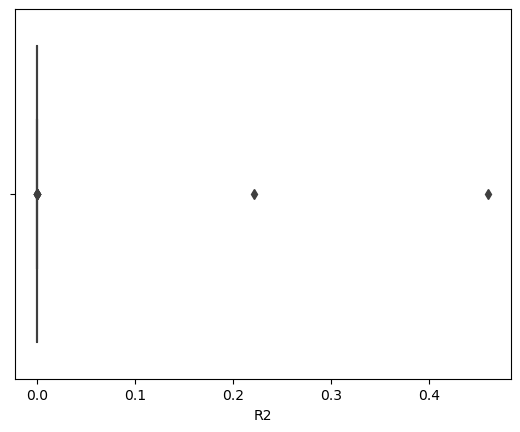

In [196]:
x=evaluationA_all['R2']
sns.boxplot(x)

<AxesSubplot:xlabel='R2'>

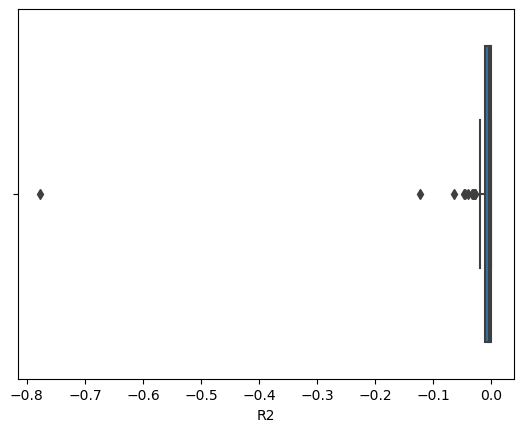

In [197]:
x=evaluationB_all['R2']
sns.boxplot(x)

In [198]:
best_params_all

,solver,max_iter,hidden_layer_sizes,activation,ID,data,randomstate,testsize
0,sgd,2000,"17,10,5,2",tanh,0,drop,1,0.4
1,sgd,2000,"17,10,5,2",tanh,1,drop,2,0.4
2,sgd,2000,"17,10,5,2",tanh,2,drop,3,0.4
3,sgd,2000,"17,10,5,2",tanh,3,drop,4,0.4
4,sgd,2000,"16,8,4,2",logistic,4,drop,5,0.4
...,...,...,...,...,...,...,...,...
95,sgd,2000,"16,8,4,2",tanh,95,drop,96,0.4
96,sgd,2000,"16,8,4,2",logistic,96,drop,97,0.4
97,sgd,2000,"16,8,4,2",tanh,97,drop,98,0.4
98,lbfgs,2000,"17,12,8,4",tanh,98,drop,99,0.4
